# Waste Management Model

## Library Initiation

In [98]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob, random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

## Dataset Loading

In [97]:
DATASET_URL = "https://storage.googleapis.com/cosmic-quarter-312712/dataset/dataset-v2.zip"
PATH_DATASET_DOWNLOADED = tf.keras.utils.get_file('dataset.zip', origin=DATASET_URL, extract=True)
PATH_DATASET = '/root/.keras/datasets/'

40845312/40845210 [==============================] - 2s 0us/step


In [99]:
os.listdir(PATH_DATASET)

['plastic', 'paper', 'cardboard', 'glass', 'dataset.zip', 'metal']

## Dataset Exploration

### Dataset Overview

In [8]:
classes = ["cardboard", "glass", "metal", "paper", "plastic"]

counts = []
for class_ in classes:
  folderPath = PATH_DATASET + class_
  count = len([name for name in os.listdir(folderPath) if os.path.isfile(os.path.join(folderPath, name))])
  counts.append(count)
  print(class_, count)

cardboard 403
glass 501
metal 410
paper 594
plastic 482


<BarContainer object of 5 artists>

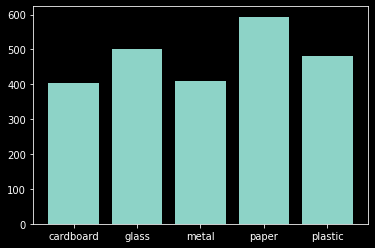

In [10]:
plt.style.use('dark_background')
plt.bar(classes, counts)

### Dataset Lookup

In [100]:
all_ds = tf.keras.preprocessing.image_dataset_from_directory(PATH_DATASET)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_DATASET,
    validation_split=0.2,
    subset='training',
    seed=0
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_DATASET,
    validation_split=0.2,
    subset='validation',
    seed=0
)

Found 2390 files belonging to 5 classes.
Found 2390 files belonging to 5 classes.
Using 1912 files for training.
Found 2390 files belonging to 5 classes.
Using 478 files for validation.


In [103]:
LIST_LABELS = all_ds.class_names
# LIST_LABELS = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
print(LIST_LABELS)

labels = '\n'.join(LIST_LABELS)
with open('labels.txt', 'w') as f:
  f.write(labels)

path = 'labels.txt'
label = np.array(open(path).read().splitlines())
print(label)

['cardboard', 'glass', 'metal', 'paper', 'plastic']
['cardboard' 'glass' 'metal' 'paper' 'plastic']


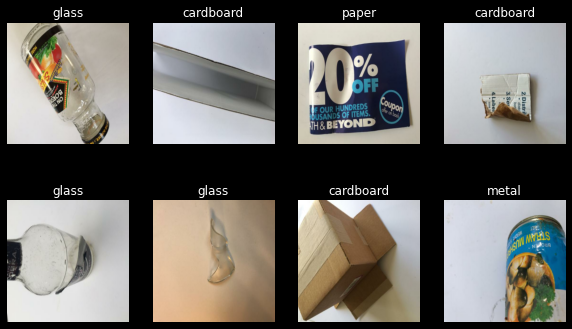

In [12]:
# train
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

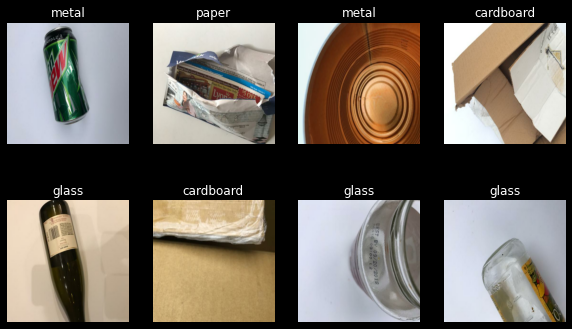

In [13]:
# validation
plt.figure(figsize=(10, 6))
for images, labels in validation_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [14]:
# inspect shape
train_batch = train_ds.as_numpy_iterator().next()

print('Total batches:', len(train_ds))
print('Images batch shape:', train_batch[0].shape)
print('Labels batch shape:', train_batch[1].shape)

Total batches: 60
Images batch shape: (32, 256, 256, 3)
Labels batch shape: (32,)


## Modeling

Modeling using transfer learning

### Base Model Loading

In [15]:
IMG_SHAPE = (256, 256,3)

In [16]:
BASE_MODEL = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

94674944/94668760 [==============================] - 1s 0us/step


### Fine-Tuning

In [17]:
BASE_MODEL.trainable = True

In [ ]:
# BASE_MODEL.summary()

In [20]:
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = BASE_MODEL.get_layer(tuning_layer_name)
tuning_index = BASE_MODEL.layers.index(tuning_layer)

for layer in BASE_MODEL.layers[:tuning_index]:
    layer.trainable =  False

### Extends Model

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.4),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
], name='data_augmentation')

In [21]:
model = tf.keras.Sequential([
    data_augmentation,
    BASE_MODEL,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

## Training

In [23]:
learning_rate = 0.00001
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50
)

Epoch 1/50
60/60 [==============================] - 42s 542ms/step - loss: 1.5433 - accuracy: 0.3311 - val_loss: 1.2181 - val_accuracy: 0.5209
Epoch 2/50
60/60 [==============================] - 28s 462ms/step - loss: 1.0583 - accuracy: 0.6297 - val_loss: 0.8802 - val_accuracy: 0.6695
Epoch 3/50
60/60 [==============================] - 28s 458ms/step - loss: 0.8078 - accuracy: 0.7291 - val_loss: 0.7042 - val_accuracy: 0.7469
Epoch 4/50
60/60 [==============================] - 28s 459ms/step - loss: 0.6818 - accuracy: 0.7720 - val_loss: 0.6060 - val_accuracy: 0.7971
Epoch 5/50
60/60 [==============================] - 28s 457ms/step - loss: 0.5830 - accuracy: 0.8101 - val_loss: 0.5390 - val_accuracy: 0.8138
Epoch 6/50
60/60 [==============================] - 28s 458ms/step - loss: 0.4998 - accuracy: 0.8421 - val_loss: 0.4960 - val_accuracy: 0.8410
Epoch 7/50
60/60 [==============================] - 28s 458ms/step - loss: 0.4646 - accuracy: 0.8536 - val_loss: 0.4646 - val_accuracy: 0.8431

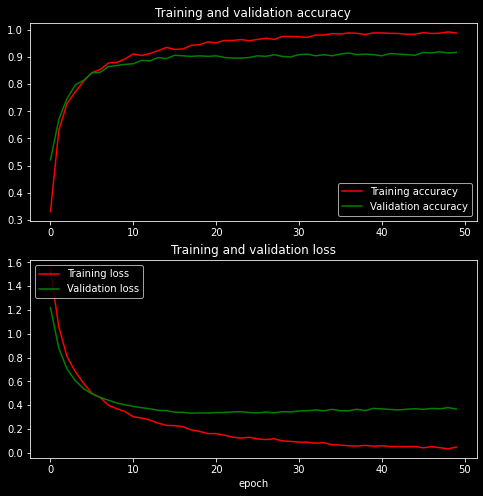

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper left')

plt.xlabel('epoch')

plt.show()

# Save & Load Model

## Library Initiation

In [37]:
import pickle

from datetime import datetime

## General Function

In [41]:
def save_model(model,
               history = None,
               model_name = 'model-waste',
               prefix_path = '',
               create_folder = True
               ):
  model_name = datetime.now().strftime("%Y-%m-%d_%H-%M") + "_" + model_name
  saved_path = os.path.join(prefix_path, model_name)

  tf.keras.models.save_model(
      model,
      saved_path,
      overwrite=True,
      include_optimizer=True,
      save_format=None,
      signatures=None,
      options=None
  )

  if history is not None:
    with open(saved_path + "/history.pickle", "wb") as f:
      pickle.dump(history.history, f)

  print("Model saved to ", saved_path)
  print("Model name : ", model_name)

  return saved_path

In [91]:
def load_model(model_name, prefix_path = ''):
  load_path = os.path.join(prefix_path, model_name)
  return tf.keras.models.load_model(load_path)

## Save & Load Model Local

#### Save & Load Function

In [86]:
def save_model_local(model, history = None, model_name = 'model-final', prefix_path = ''):
  export_path = save_model(model, history, model_name, prefix_path)

  print('\nSaved to local:')
  !ls -l {export_path}

In [94]:
def load_model_local (model_name, prefix_path = 'models'):
  model = load_model(model_name, prefix_path)
  print('Loaded from Local')
  return model

#### Testing Save & Load

In [89]:
# save_model_local(model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: models/2021-05-28_23-57_model-final/assets
Model saved to  models/2021-05-28_23-57_model-final
Model name :  2021-05-28_23-57_model-final

Saved to local:
total 5528
drwxr-xr-x 2 root root    4096 May 28 23:58 assets
-rw-r--r-- 1 root root  593691 May 28 23:58 keras_metadata.pb
-rw-r--r-- 1 root root 5057127 May 28 23:58 saved_model.pb
drwxr-xr-x 2 root root    4096 May 28 23:58 variables


In [95]:
# model = load_model_local('2021-05-28_23-57_model-final')

Loaded from Local


## Save & Load Model GDrive

#### Authenticate



In [71]:
from google.colab import drive
drive.mount("drive", force_remount=True)

Mounted at drive


In [63]:
PATH_GDRIVE = "drive/Shareddrives/B21-CAP0331/models/"

#### Save & Load Function

In [69]:
def save_model_gdrive (model, history = None, model_name = '', prefix_path = PATH_GDRIVE):
  export_path = save_model(model, history, model_name, prefix_path)

  drive.flush_and_unmount()
  print("Drive flushed out")
  drive.mount("drive")

  print('\nSaved to GDrive:')
  !ls -l {export_path}

In [108]:
def load_model_gdrive (model_name, prefix_path = PATH_GDRIVE):
  model = load_model(model_name, prefix_path)
  print('Loaded from GDrive')
  return model

#### Testing Save & Load

In [72]:
# save_model_gdrive(model, model_name='model-final-v1')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/Shareddrives/B21-CAP0331/models/2021-05-28_23-48_model-final-v1/assets
Model saved to  drive/Shareddrives/B21-CAP0331/models/2021-05-28_23-48_model-final-v1
Model name :  2021-05-28_23-48_model-final-v1
Drive flushed out
Mounted at drive

Saved to GDrive:
total 5527
drwx------ 2 root root    4096 May 28 23:49 assets
-rw------- 1 root root  593691 May 28 23:49 keras_metadata.pb
-rw------- 1 root root 5057127 May 28 23:49 saved_model.pb
drwx------ 2 root root    4096 May 28 23:49 variables


In [152]:
# model = load_model_gdrive ('2021-05-21_14-52_model-build-v3_resnet50v2_fine-tune_50epochs') # v3

Loaded from GDrive


## Save & Load Model Cloud

#### Authenticate



In [155]:
from google.colab import auth
auth.authenticate_user()

In [148]:
GCP_PROJECT = 'cosmic-quarter-312712'
GCP_BUCKET = 'gs://' + GCP_PROJECT + '-tf2-models'
VERSION_MODEL = 'v1'
DELIMITER = '-'
MODEL_NAME = 'waste' + DELIMITER + VERSION_MODEL
MODEL_URL = os.path.join("gs://", GCP_BUCKET, MODEL_NAME)

#### Save & Load Function

In [ ]:
def save_model_gcp(model, model_path = MODEL_URL):
 
  tf.keras.models.save_model(
      model,
      model_path,
      overwrite=True,
      include_optimizer=True,
      save_format=None,
      signatures=None,
      options=None
  )
 
  print('\nSaved to GCP')

In [ ]:
def load_model_gcp (model_path = MODEL_URL):
  model = load_model(model_path)
  print('Loaded from GCP')
  return model

#### Testing Save & Load

In [122]:
# save_model_gcp(model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: gs://cosmic-quarter-312712-tf2-models/waste-v1/assets

Saved to GCP


In [163]:
# model = load_model_gcp() # v4

Loaded from GCP


# Test on validation dataset (v3)

In [158]:
wrong_ds = []

counter = {
    0: [0] * 5,
    1: [0] * 5,
    2: [0] * 5,
    3: [0] * 5,
    4: [0] * 5,
}

for i, (img, label) in enumerate(validation_ds.unbatch()):
  img = img.numpy().astype("uint8")

  predict_label = model.predict(img[np.newaxis, ...])
  predict_label_idx = np.argmax(predict_label[0], axis=-1)

  if (predict_label_idx != label):
    wrong_ds.append((img, predict_label, label))

  counter[label.numpy()][predict_label_idx] += 1

print(counter)
# sort based true label
wrong_ds.sort(key=lambda x: x[2])
len(wrong_ds)

{0: [67, 0, 0, 7, 0], 1: [1, 83, 5, 0, 5], 2: [0, 1, 79, 2, 0], 3: [2, 0, 1, 123, 1], 4: [1, 6, 2, 3, 89]}


37

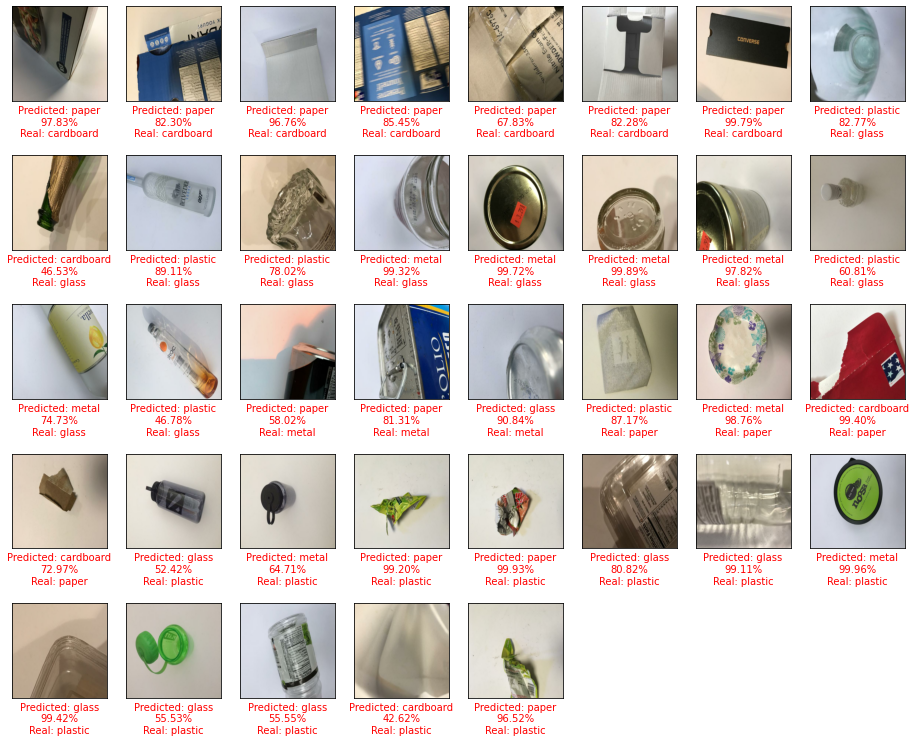

In [159]:
plt.figure(figsize=(16, 16))
for i, (img, predicted_label, label) in enumerate(wrong_ds):
  ax = plt.subplot(6, 8, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
  ax.xaxis.label.set_color('red')
  plt.xlabel('Predicted: {}\n{:.2f}%\nReal: {}'.format(LIST_LABELS[np.argmax(predicted_label)], 100 * np.max(predicted_label), LIST_LABELS[label]))
plt.show()

# Test on validation dataset (v4)

In [164]:
wrong_ds = []

counter = {
    0: [0] * 5,
    1: [0] * 5,
    2: [0] * 5,
    3: [0] * 5,
    4: [0] * 5,
}

for i, (img, label) in enumerate(validation_ds.unbatch()):
  img = img.numpy().astype("uint8")

  predict_label = model.predict(img[np.newaxis, ...])
  predict_label_idx = np.argmax(predict_label[0], axis=-1)

  if (predict_label_idx != label):
    wrong_ds.append((img, predict_label, label))

  counter[label.numpy()][predict_label_idx] += 1

print(counter)
# sort based true label
wrong_ds.sort(key=lambda x: x[2])
len(wrong_ds)

{0: [68, 0, 0, 6, 0], 1: [0, 79, 9, 0, 6], 2: [0, 1, 77, 2, 2], 3: [2, 0, 1, 123, 1], 4: [1, 5, 1, 4, 90]}


41

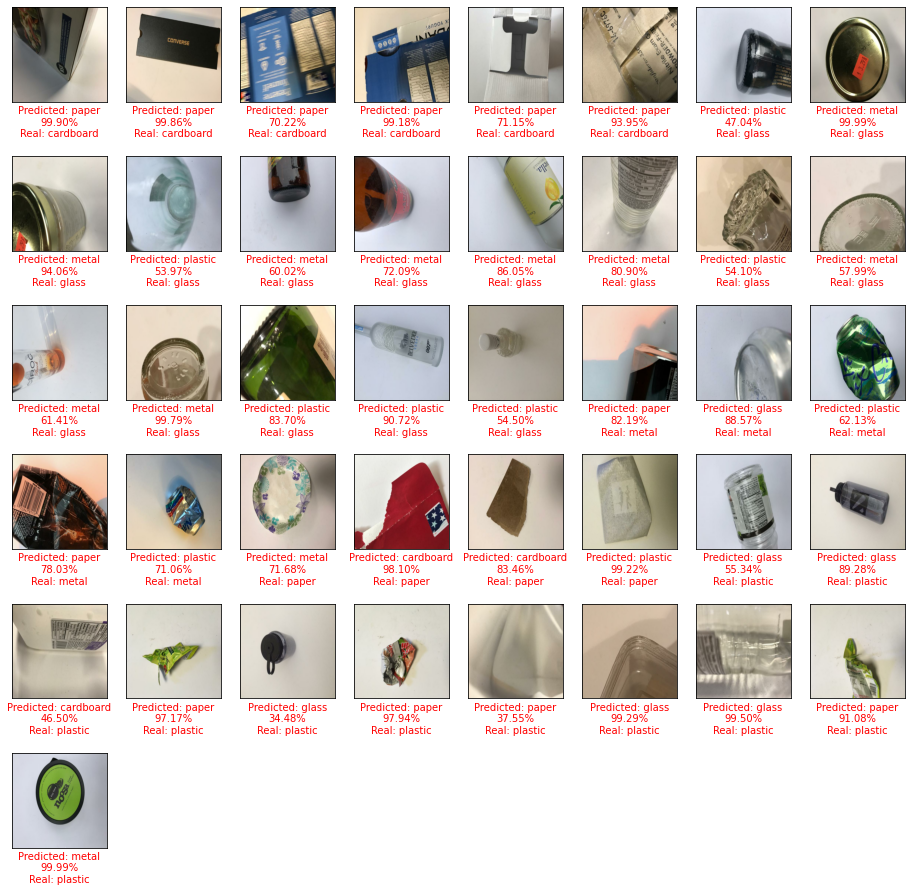

In [165]:
plt.figure(figsize=(16, 16))
for i, (img, predicted_label, label) in enumerate(wrong_ds):
  ax = plt.subplot(6, 8, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
  ax.xaxis.label.set_color('red')
  plt.xlabel('Predicted: {}\n{:.2f}%\nReal: {}'.format(LIST_LABELS[np.argmax(predicted_label)], 100 * np.max(predicted_label), LIST_LABELS[label]))
plt.show()

# Test on unseen data

## v3

In [153]:
PATH_UNSEEN_DATASET = 'drive/Shareddrives/B21-CAP0331/dataset/unlabeled-testing/'

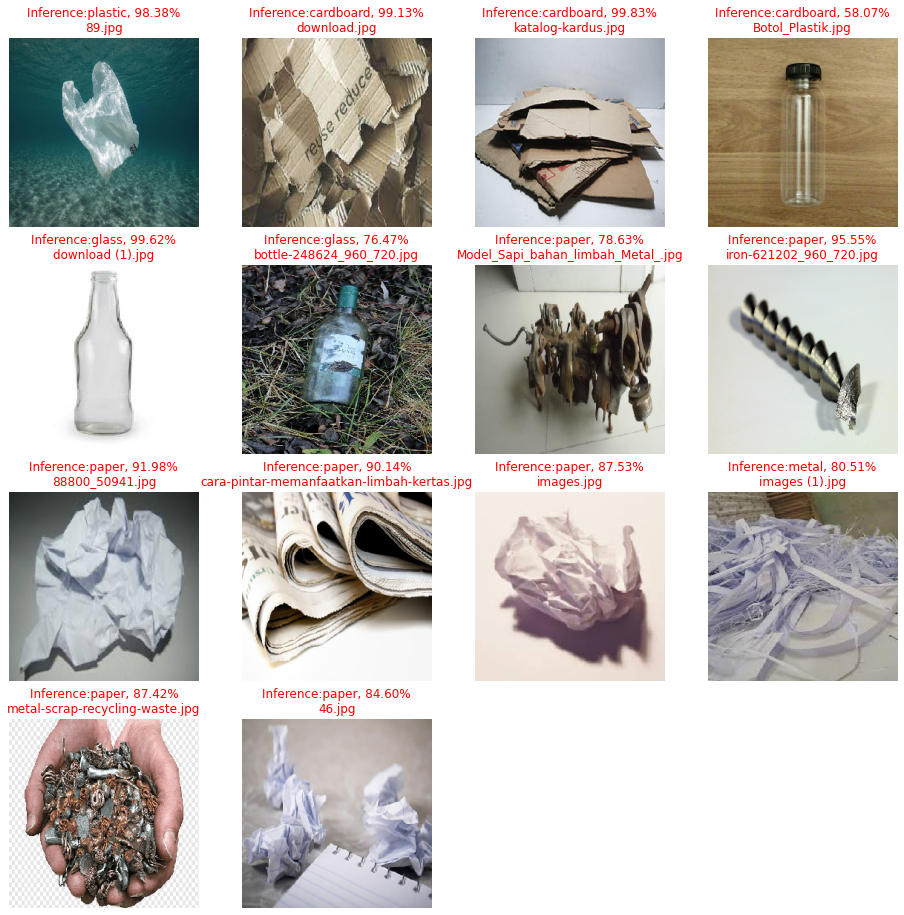

In [162]:
test_paths = os.listdir(PATH_UNSEEN_DATASET)
test_ds = []
image_size = (256, 256)

for i in range(len(test_paths)):
    path = PATH_UNSEEN_DATASET + test_paths[i]
    img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
    test_ds.append(tf.keras.preprocessing.image.img_to_array(img))

test_ds = np.array(test_ds)

test_inference = model.predict_on_batch(test_ds)

plt.figure(figsize=(16, 16))
for i in range(len(test_ds)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title(
        'Inference:{}, {:.2f}%\n{}'
        .format(LIST_LABELS[np.argmax(test_inference[i])], 100 * np.max(test_inference[i]), test_paths[i]),
        { 'color' : 'r' }
        )
    plt.axis("off")

## v4

In [150]:
PATH_UNSEEN_DATASET = 'drive/Shareddrives/B21-CAP0331/dataset/unlabeled-testing/'

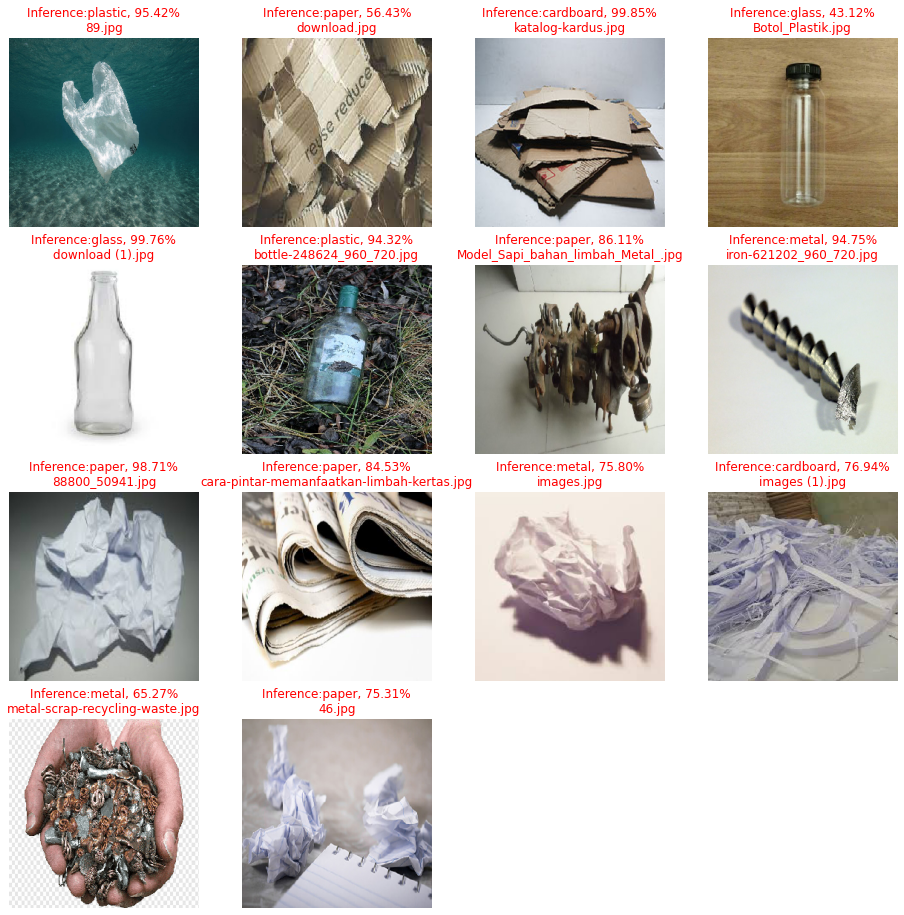

In [166]:
test_paths = os.listdir(PATH_UNSEEN_DATASET)
test_ds = []
image_size = (256, 256)

for i in range(len(test_paths)):
    path = PATH_UNSEEN_DATASET + test_paths[i]
    img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
    test_ds.append(tf.keras.preprocessing.image.img_to_array(img))

test_ds = np.array(test_ds)

test_inference = model.predict_on_batch(test_ds)

plt.figure(figsize=(16, 16))
for i in range(len(test_ds)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title(
        'Inference:{}, {:.2f}%\n{}'
        .format(LIST_LABELS[np.argmax(test_inference[i])], 100 * np.max(test_inference[i]), test_paths[i]),
        { 'color' : 'r' }
        )
    plt.axis("off")